**Copy your Colab link here:** https://colab.research.google.com/drive/1PCftom3Pqn4wR0AcYiovDB5aOcE1A7gb?usp=sharing

Import packages here

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.io


**Step 0. Moving the lab to your folder**

Duplicate this notebook (as you won't have write permission to this) to your Google Drive.
This can be done by clicking on *File Menu - Save a copy in Drive*

Run to mount your google drives:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Your drive would be accessed as '/content/drive/MyDrive' for Colab. You may need to put your data and creating a 'results' folder somewhere in the drive. The 'results' folder could be used for storing the required outputs.   

In [3]:
# example goes like:
path_data  = '/content/drive/MyDrive/lab6/Final_digits'

**Load data**

In [7]:
data_files = glob("/content/drive/MyDrive/lab6/Final_digits/*.mat")
data_dict = {}
for file in data_files:
    key = file.split('/')[-1].replace('.mat', '')
    try:
        data = scipy.io.loadmat(file)['feat']
        if len(data.shape) == 3:
            data = data[0]  # Remove extra dimension if present
        if len(data.shape) == 2 and data.shape[1] == 13:
            data_dict[key] = data
        else:
            print(f"Skipping {file} due to incorrect shape: {data.shape}")
    except KeyError:
        print(f"Skipping {file} due to missing 'feat' key")

In [8]:
# Cell 3: Define digits
digits = [str(i) for i in range(10)]

In [9]:
def normalize_features(data):
    # Normalize along the time axis (rows)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / (std + 1e-8)  # Adding small epsilon to prevent division by zero

**Implementing DTW**


In [29]:
def dtw_cost(T, R):
    M, _ = T.shape
    N, _ = R.shape
    S = np.zeros((M, N))

    # Compute the dissimilarity matrix S using Euclidean distance
    for i in range(M):
        for j in range(N):
            S[i, j] = np.linalg.norm(T[i] - R[j])

    # Compute accumulated DTW matrix D
    D = np.zeros((M, N))
    D[0, 0] = S[0, 0]

    # Fill in the rest of the matrix
    for m in range(1, M):
        D[m, 0] = S[m, 0] + D[m-1, 0]
    for n in range(1, N):
        D[0, n] = S[0, n] + D[0, n-1]
    for m in range(1, M):
        for n in range(1, N):
            D[m, n] = S[m, n] + min(D[m-1, n], D[m, n-1], D[m-1, n-1])

    # Return the final accumulated cost (D[M-1, N-1])
    return D[M-1, N-1]


In [11]:
# Cell 6: Define new confusion matrix and reset counters
conf_matrix_improved = np.zeros((10, 10), dtype=int)
correct_matches = 0
total_comparisons = 0
digit_accuracies = {digit: [] for digit in digits}

# Track problematic keys due to shape issues
problematic_keys = []

**Draw the path for DTW between "4_jackson_8" and "9_jackson_5" as an example**

In [42]:
# Load example data
example_T = scipy.io.loadmat('/content/drive/MyDrive/lab6/Final_digits/4_jackson_8.mat')['feat'][0]
example_R = scipy.io.loadmat('/content/drive/MyDrive/lab6/Final_digits/9_jackson_5.mat')['feat'][0]

# Check if example data is loaded correctly
if example_T is not None and example_R is not None:
    # Normalize the example data and ensure 2D shape
    if len(example_T.shape) == 3:
        example_T = example_T[0]
    if len(example_R.shape) == 3:
        example_R = example_R[0]

    # Define normalization function if not already defined
    def normalize_features(data):
        return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

    example_T = normalize_features(example_T)
    example_R = normalize_features(example_R)

    # Define DTW function to calculate cost and path
    def dtw_cost_and_path(T, R):
        M, _ = T.shape
        N, _ = R.shape
        S = np.zeros((M, N))

        # Compute the dissimilarity matrix S using Euclidean distance
        for i in range(M):
            for j in range(N):
                S[i, j] = np.linalg.norm(T[i] - R[j])


        # Backtrack to find the optimal path
        path = []
        m, n = M - 1, N - 1
        while m > 0 or n > 0:
            path.append((m, n))
            if m == 0:
                n -= 1
            elif n == 0:
                m -= 1
            else:
                steps = [D[m-1, n], D[m, n-1], D[m-1, n-1]]
                step_idx = np.argmin(steps)
                if step_idx == 0:
                    m -= 1
                elif step_idx == 1:
                    n -= 1
                else:
                    m -= 1
                    n -= 1
        path.append((0, 0))
        path.reverse()

        # Return the final accumulated cost and the path
        return D[M-1, N-1], path

    # Calculate DTW cost and path
    cost, path = dtw_cost_and_path(example_T, example_R)



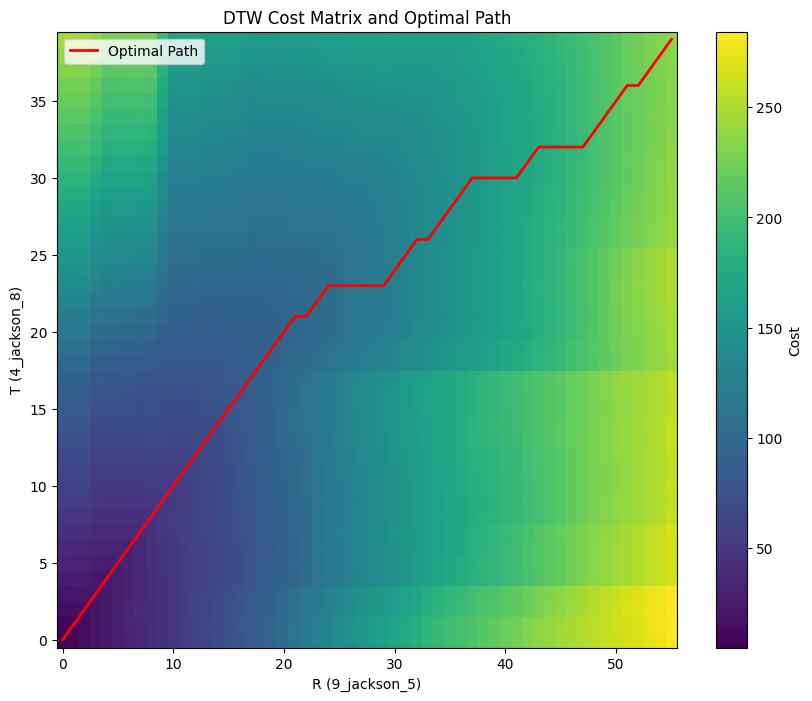

In [43]:
plt.figure(figsize=(10, 8))
M, N = example_T.shape[0], example_R.shape[0]
D = np.zeros((M, N))

# Calculate the cost matrix D
for i in range(M):
    for j in range(N):
        D[i, j] = np.linalg.norm(example_T[i] - example_R[j])

# Accumulate the cost matrix along the edges
for m in range(1, M):
    D[m, 0] += D[m-1, 0]
for n in range(1, N):
    D[0, n] += D[0, n-1]

# Accumulate the cost matrix for the rest of the elements
for m in range(1, M):
    for n in range(1, N):
        D[m, n] += min(D[m-1, n], D[m, n-1], D[m-1, n-1])

# Plot the DTW cost matrix and optimal path
plt.imshow(D, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Cost')
path_x, path_y = zip(*path)
plt.plot(path_y, path_x, color='red', linewidth=2, label='Optimal Path')
plt.xlabel('R (9_jackson_5)')
plt.ylabel('T (4_jackson_8)')
plt.title('DTW Cost Matrix and Optimal Path')
plt.legend()
plt.show()


**Sort them and take least 29 values ( because you have 29 utterances of same digit). Now, check if the utterances corresponding to those 29 values are of same digit and note down number of comparisons that yielded the same digit as T.**

In [13]:
# Cell 7: Calculate DTW costs with normalized data and update confusion matrix
for test_key, test_data in data_dict.items():
    # Normalize the test data
    test_data = normalize_features(test_data)

    alignment_costs = []

    # Compare test utterance with all other reference utterances
    for ref_key, ref_data in data_dict.items():
        if test_key != ref_key:  # Skip comparing to itself
            # Normalize the reference data
            ref_data = normalize_features(ref_data)

            try:
                cost = dtw_cost(test_data, ref_data)
                alignment_costs.append((cost, ref_key))
            except ValueError as e:
                print(f"Error in DTW comparison between {test_key} and {ref_key}: {e}")

    # Sort the alignment costs and get the 29 least values
    if len(alignment_costs) > 0:
        alignment_costs.sort()
        top_29 = alignment_costs[:29]

        # Count the number of correct matches (same digit)
        test_digit = test_key.split('_')[0]
        correct_count = sum(1 for _, ref_key in top_29 if ref_key.split('_')[0] == test_digit)

        # Update total correct matches and total comparisons
        correct_matches += correct_count
        total_comparisons += 29

        # Record accuracy for the current digit
        digit_accuracies[test_digit].append(correct_count / 29)

        # Update confusion matrix
        for _, ref_key in top_29:
            ref_digit = ref_key.split('_')[0]
            conf_matrix_improved[int(test_digit), int(ref_digit)] += 1

**Report the compute accuracy for each digit as well as overall accuracy. Make a confusion matrix to store it. Confusion matrix will have information of how many times each digit is confused with other digits. Display it by the end of the notebook.**

In [14]:
# Cell 8: Compute overall accuracy after normalization
if total_comparisons > 0:
    overall_accuracy_improved = correct_matches / total_comparisons
    print("Overall Accuracy after Normalization:", overall_accuracy_improved)
else:
    print("No comparisons to calculate accuracy.")

# Cell 9: Compute and print accuracy for each digit after normalization
print("\nAccuracy for each digit after Normalization:")
for digit in digits:
    if digit_accuracies[digit]:
        digit_accuracy = np.mean(digit_accuracies[digit])
        print(f"Digit {digit}: {digit_accuracy:.2f}")
    else:
        print(f"Digit {digit}: No data available")



Overall Accuracy after Normalization: 0.37057471264367814

Accuracy for each digit after Normalization:
Digit 0: 0.37
Digit 1: 0.51
Digit 2: 0.41
Digit 3: 0.44
Digit 4: 0.37
Digit 5: 0.40
Digit 6: 0.32
Digit 7: 0.26
Digit 8: 0.29
Digit 9: 0.34


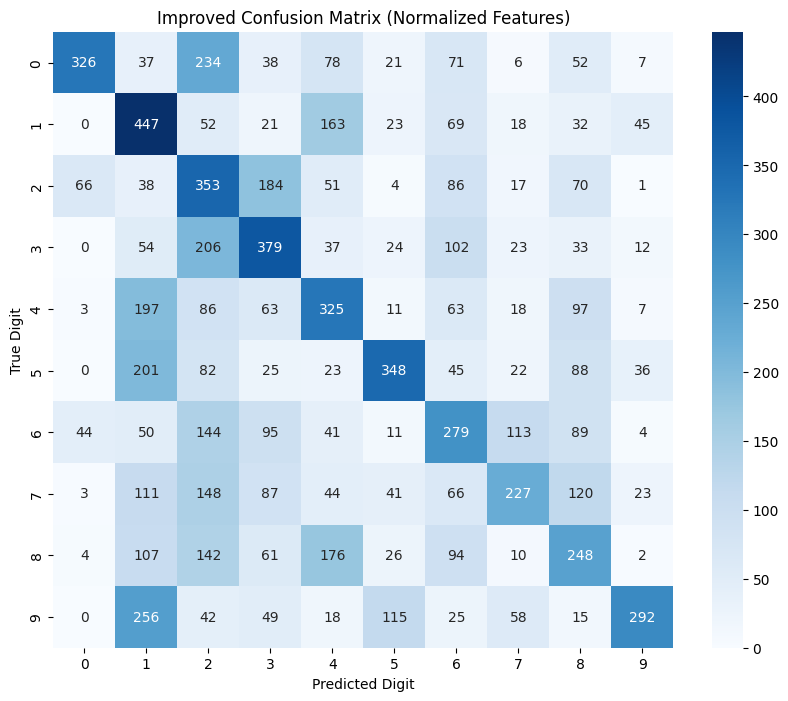

In [17]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_improved, annot=True, cmap='Blues', xticklabels=digits, yticklabels=digits, fmt='d')
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.title('Improved Confusion Matrix (Normalized Features)')
plt.show()

**You are ready to submit in Canvas!**

4 easy steps to submit your lab:

1.   Go to "File" - Download ".ipynb" and ".py" files
2.   Click on "Share" option on top right - Click on "copy link" option. Make sure your permission is set to "Anyone on the internet with this link can view"
3.   Upload the ".ipynb" file obtained from Step (1) with your 'results' folder to Canvas. If it is too big, zip it before uploading.
4.   In the text comments on Canvas, paste the link obtained from Step (3).

That's it!

In short, we want to have one link, one .ipynb, one ".py" and one 'Lab9_FirstnameLastname_yourJHID.zip' containing all the required data and outputs.
